## 1.2 Download


We want to download the monthly precipitation for february. I use the automatically generated request from the CDS server. There are two datasets we can use to download the data: [Seasonal forecast daily data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-original-single-levels?tab=form) and [Seasonal forecast monthly statistics on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form). We will use the latter for easy downloading of the monthly values. If we want to go to higher temporal resolution, such as daily extremes, we will have to consult the other dataset. 

In our request, we will use the monthly mean. Interestingly, there is also the option to use the monthly maximum! We previously downloaded the data on daily resolution and extracted the monthly (or seasonal) maximum from that data. If we could just download the monthly maximum instead that might save a lot of processing power! However, you would be restricted to daily extremes only, for multi-day extremes (5 days is often used), you would have to do the original processing workflow.


We select the UK domain to reduce the size of the download.

### Import packages

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [9]:
##import packages
import os
import cdsapi ## check the current working directory, which should be the UNSEEN-open directory
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

In [3]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open/Notebooks/1.Download'

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

### First download

Here I download the monthly mean total precipitation (both convective and large scale precipitation) forecast for February 1993. It downloads all 25 ensemble members for the forecasts initialized in january.    

In [4]:
##Our first download:

c = cdsapi.Client()

c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'netcdf',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation',
        'product_type': [
            'monthly_mean', #'monthly_maximum',, 'monthly_standard_deviation',  
        ],
        'year': '1993', #data before 1993 is available.  
        'month': '01', #Initialization month. Target month is February (2), initialization months are August-January (8-12,1)
        'leadtime_month': [ ##Use of single months is much faster. Leadtime 0 does not exist. The first lead time is 1.
            '1', '2',
        ],
        'area': [##Select UK domain to reduce the size of the download
            60, -11, 50,
            2,
        ],
    },
    'Data/First_download.nc') ##can I use nc? yes! 

2020-05-13 10:08:56,140 INFO Welcome to the CDS
2020-05-13 10:08:56,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-13 10:08:56,983 INFO Request is completed
2020-05-13 10:08:56,984 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.external-1589266964.5635436-26283-29-a38e8975-b0ec-49ee-8f9b-7dea389f59cf.nc to Data/First_download.nc (16.4K)
2020-05-13 10:08:57,131 INFO Download rate 112.7K/s


Result(content_length=16800,content_type=application/x-netcdf,location=http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.external-1589266964.5635436-26283-29-a38e8975-b0ec-49ee-8f9b-7dea389f59cf.nc)

## Use xarray to visualize the netcdf file

I open the downloaded file and plot February 1993 precipitation over the UK. 

In [5]:
pr_1993_ds=xr.open_dataset('Data/First_download.nc')
pr_1993_ds


<xarray.Dataset>
Dimensions:    (latitude: 11, longitude: 14, number: 25, time: 2)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01
Data variables:
    tprate     (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-12 07:02:45 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

I select ensemble member 0 and february precipitation ('tprate' called apparently) and I use cartopy to make the map. 

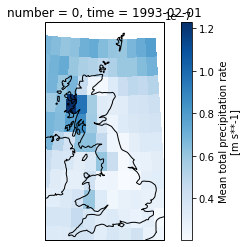

In [6]:
## Use cartopy for nicer maps
ax = plt.axes(projection= ccrs.OSGB()) 
pr_1993_ds['tprate'].sel(number=0,time='1993-02').plot(transform=ccrs.PlateCarree(),cmap=plt.cm.Blues, ax=ax)  #,cmap=plt.cm.Blues,

# ax.set_extent(extent)
ax.coastlines(resolution='50m')
plt.draw()

## Download all data

We will be using the SEAS5 hindcast, which is a dataset running from 1981-2016. The hindcast is initialized every month with 25 ensemble members and the forecast run for 6 months, indicated by blue horizontal bars below. February is forecasted by 6 initialization months (September-February). We discard the first month of the forecast because of dependence between the forecasts, explained in the evaluation section and are left with 5 initialization months (Sep-Jan) and 25 ensemble members forecasting february precipitation each year, totalling to an increase of 125 times the observed length.

For a summary of all available C3S seasonal hindcasts, their initialization months and more specifics, please see [ECMWF page](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts) and the [SEAS5 paper](https://doi.org/10.5194/gmd-12-1087-2019).  



![title](../../graphs/Data_illustration.png)

The first download example above downloaded all 25 ensemble members for the forecast initialized in January (the bottom bar). We should repeat this over the other initialization month and over all years (1981-2016).

In [58]:
init_months = np.append(np.arange(9,13),1) ## Initialization months 9-12,1 (Sep-Jan)
init_months 
years = np.arange(1982,2017)
years


array([ 9, 10, 11, 12,  1])

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016])

For our download, we loop over initialization months and years. Because we only want February precipitation, the leadtime month (forecast length) changes with the initialization month. For example, in the September initialized forecasts, we only want the leadtime month 6 = February. For August initialized this is leadtime 5, etc. Furthermore, the year the forecast is initialized is required for the download. For September - December initialized forecasts, this is the target year-1. For January it is the same year as the target year. For example, for the first two target years this looks like the following:

In [81]:

for j in range(2):#len(years)):
    for i in range(len(init_months)):
        init_month = init_months[i]
        leadtime_month = 6-i
        if init_month == 1:
            year = years[j]
        else:
            year = years[j]-1
        print ('year = ' + str(year) +' init_month = ' + str(init_month) + ' leadtime_month = ' + str(leadtime_month))

year = 1981 init_month = 9 leadtime_month = 6
year = 1981 init_month = 10 leadtime_month = 5
year = 1981 init_month = 11 leadtime_month = 4
year = 1981 init_month = 12 leadtime_month = 3
year = 1982 init_month = 1 leadtime_month = 2
year = 1982 init_month = 9 leadtime_month = 6
year = 1982 init_month = 10 leadtime_month = 5
year = 1982 init_month = 11 leadtime_month = 4
year = 1982 init_month = 12 leadtime_month = 3
year = 1983 init_month = 1 leadtime_month = 2


Write a function that is used for the download.

In [72]:
def retrieve(variable, originating_centre, year, init_month, leadtime_month):
    
    c.retrieve(
        'seasonal-monthly-single-levels',
        {
            'format': 'netcdf',
            'originating_centre': originating_centre,
            'system': '5',
            'variable': variable,
            'product_type': [
                'monthly_mean', #'monthly_maximum',, 'monthly_standard_deviation',  
            ],
            'year': str(year), #data before 1993 is available.  
            'month': "%.2i" % init_month, #Initialization month. Target month is February (2), initialization months are August-January (8-12,1)
            'leadtime_month': [ ##The lead times you want. Use of single months is much faster. Leadtime 0 does not exist. The first lead time is 1.
                #For initialization month 1 (January), the leadtime months is 2 (February). For initialization month 12 (december), the lead time month is 3 (February).
                str(leadtime_month),
            ],
            'area': [##Select UK domain to reduce the size of the download
                60, -11, 50,
                2,
            ],
        },
        '../UK_example/'+ str(year) + "%.2i" % init_month + '.nc')
    
# retrieve(variable = 'total_precipitation',originating_centre = 'ecmwf', year = years[0], init_month = "%.2i" % init_months[0])
    
    

And start the download! In total, we request 35 years x  initialization dates = 175 requests. 
I could try sending just 5 request of the different initialization dates for all years?

In [ ]:
for j in range(len(years)):  ##add if error still continue
    for i in range(len(init_months)):
        init_month = init_months[i]
        leadtime_month = 6-i
        if init_month == 1:
            year = years[j]
        else:
            year = years[j]-1
        retrieve(variable = 'total_precipitation',originating_centre = 'ecmwf', year = year, 
                 init_month = init_month, leadtime_month = leadtime_month)


2020-05-14 11:05:05,192 INFO Welcome to the CDS
2020-05-14 11:05:05,195 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:05:05,368 INFO Request is completed
2020-05-14 11:05:05,371 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data5/adaptor.mars.external-1589380912.7108843-4209-7-1add31ae-a0cd-44ce-83ac-9ff7c97f1b01.nc to ../UK_example/198109.nc (8.9K)
2020-05-14 11:05:05,490 INFO Download rate 75.1K/s
2020-05-14 11:05:05,562 INFO Welcome to the CDS
2020-05-14 11:05:05,563 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:05:05,751 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.external-1589381056.172494-12462-1-c9714216-87ac-49bc-be19-260627a9077d.nc to ../UK_example/198110.nc (8.9K)
2020-05-14 11:05:05,800 INFO Download rate 189.8K/s
2020-05-14 11:05:05,866 INFO Welcome to the CDS
2020-05-1

2020-05-14 11:05:11,183 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data5/adaptor.mars.external-1589382331.845724-18604-5-9a6c27f7-ebec-46a4-a130-43b461c5d84f.nc to ../UK_example/198412.nc (8.9K)
2020-05-14 11:05:11,262 INFO Download rate 113.1K/s
2020-05-14 11:05:11,412 INFO Welcome to the CDS
2020-05-14 11:05:11,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:05:11,481 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data9/adaptor.mars.external-1589382338.3577514-8197-15-d24d796e-f472-4d2f-a2f7-8bab12cc31c7.nc to ../UK_example/198501.nc (8.9K)
2020-05-14 11:05:11,591 INFO Download rate 81.7K/s
2020-05-14 11:05:11,811 INFO Welcome to the CDS
2020-05-14 11:05:11,812 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:05:11,865 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data4/adaptor.mars

2020-05-14 11:05:17,231 INFO Download rate 83.6K/s
2020-05-14 11:05:17,320 INFO Welcome to the CDS
2020-05-14 11:05:17,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:05:17,438 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data5/adaptor.mars.external-1589383252.6368706-9123-26-cb2cb76a-28da-499c-a9a7-95f5e61fb5a0.nc to ../UK_example/198811.nc (8.9K)
2020-05-14 11:05:17,502 INFO Download rate 142K/s
2020-05-14 11:05:17,585 INFO Welcome to the CDS
2020-05-14 11:05:17,587 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:05:17,622 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data1/adaptor.mars.external-1589383303.7140825-27955-13-de74c342-fcdf-405a-8fcc-4f00eff1efbd.nc to ../UK_example/198812.nc (8.9K)
2020-05-14 11:05:17,697 INFO Download rate 119.5K/s
2020-05-14 11:05:17,760 INFO Welcome to the CDS
2020-05

2020-05-14 11:13:41,521 INFO Welcome to the CDS
2020-05-14 11:13:41,523 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:13:41,754 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data3/adaptor.mars.external-1589384779.1501586-5346-29-c6e64b4c-adad-4493-8856-58ecf2db5a5d.nc to ../UK_example/199209.nc (8.9K)
2020-05-14 11:13:41,796 INFO Download rate 217.8K/s
2020-05-14 11:13:41,868 INFO Welcome to the CDS
2020-05-14 11:13:41,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:13:42,086 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data1/adaptor.mars.external-1589384791.158574-22528-14-c71849d5-1983-40bf-8e64-3c8f931cd827.nc to ../UK_example/199210.nc (8.9K)
2020-05-14 11:13:42,132 INFO Download rate 200.4K/s
2020-05-14 11:13:42,349 INFO Welcome to the CDS
2020-05-14 11:13:42,352 INFO Sending request to https://

2020-05-14 11:19:07,239 INFO Download rate 92.6K/s
2020-05-14 11:19:07,575 INFO Welcome to the CDS
2020-05-14 11:19:07,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:19:08,063 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data4/adaptor.mars.external-1589385880.5496118-13618-23-236ac4df-fea4-483d-addf-eec62eb4413d.nc to ../UK_example/199512.nc (8.9K)
2020-05-14 11:19:08,120 INFO Download rate 157.8K/s
2020-05-14 11:19:08,752 INFO Welcome to the CDS
2020-05-14 11:19:08,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:19:09,082 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data8/adaptor.mars.external-1589386117.3937304-8459-12-eafc112e-4b5c-4a0a-9088-88dfc7785816.nc to ../UK_example/199601.nc (8.9K)
2020-05-14 11:19:09,127 INFO Download rate 202.1K/s
2020-05-14 11:19:09,633 INFO Welcome to the CDS
2020-

2020-05-14 11:24:21,325 INFO Download rate 103K/s
2020-05-14 11:24:22,292 INFO Welcome to the CDS
2020-05-14 11:24:22,293 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:24:23,435 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.external-1589388153.4673803-25092-31-3b954a00-7f6d-40b7-a24b-22908fbfb1a6.nc to ../UK_example/199910.nc (8.9K)
2020-05-14 11:24:23,546 INFO Download rate 80.7K/s
2020-05-14 11:24:25,312 INFO Welcome to the CDS
2020-05-14 11:24:25,314 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:24:25,904 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data6/adaptor.mars.external-1589388177.467626-13579-32-50121b67-d039-4bd3-b18c-65ff286b247a.nc to ../UK_example/199911.nc (8.9K)
2020-05-14 11:24:25,969 INFO Download rate 137.8K/s
2020-05-14 11:24:27,270 INFO Welcome to the CDS
2020-05

2020-05-14 11:27:37,253 INFO Welcome to the CDS
2020-05-14 11:27:37,254 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:27:37,352 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.external-1589389366.0117645-11909-19-c54bda8e-a787-463b-8cb4-b0bfa8a657ce.nc to ../UK_example/200301.nc (8.9K)
2020-05-14 11:27:37,425 INFO Download rate 124.5K/s
2020-05-14 11:27:37,592 INFO Welcome to the CDS
2020-05-14 11:27:37,593 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:27:37,651 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data6/adaptor.mars.external-1589389439.2823322-20600-15-3dbd76fc-19d4-4e32-acb7-b3313e33c76a.nc to ../UK_example/200309.nc (8.9K)
2020-05-14 11:27:37,700 INFO Download rate 186.4K/s
2020-05-14 11:27:37,939 INFO Welcome to the CDS
2020-05-14 11:27:37,940 INFO Sending request to https:

2020-05-14 11:42:45,909 INFO Download rate 307.8K/s
2020-05-14 11:42:46,006 INFO Welcome to the CDS
2020-05-14 11:42:46,007 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:42:46,105 INFO Request is queued
2020-05-14 11:44:39,641 INFO Request is running
2020-05-14 11:45:37,379 INFO Request is completed
2020-05-14 11:45:37,380 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data5/adaptor.mars.external-1589449474.0341363-12082-19-50f6464a-a244-4e84-ba66-82d78c91d2b5.nc to ../UK_example/200609.nc (8.9K)
2020-05-14 11:45:37,411 INFO Download rate 296.3K/s
2020-05-14 11:45:37,517 INFO Welcome to the CDS
2020-05-14 11:45:37,518 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:45:37,676 INFO Request is queued
2020-05-14 11:47:31,285 INFO Request is completed
2020-05-14 11:47:31,287 INFO Downloading http://136.156.132.235/cache-compute-0

2020-05-14 11:58:37,666 INFO Request is completed
2020-05-14 11:58:37,667 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data7/adaptor.mars.external-1589450313.6932511-16585-5-ceacdcbd-2f00-4b99-ab04-879d4c7f2d16.nc to ../UK_example/200901.nc (8.9K)
2020-05-14 11:58:37,700 INFO Download rate 284.1K/s
2020-05-14 11:58:37,838 INFO Welcome to the CDS
2020-05-14 11:58:37,839 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 11:58:38,174 INFO Request is queued
2020-05-14 11:58:39,189 INFO Request is running
2020-05-14 11:58:42,970 INFO Request is completed
2020-05-14 11:58:42,971 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data7/adaptor.mars.external-1589450318.4837189-4048-29-0e413cff-b1d2-422c-908d-34e627241bca.nc to ../UK_example/200909.nc (8.9K)
2020-05-14 11:58:42,994 INFO Download rate 408.1K/s
2020-05-14 11:58:43,093 INFO Welcome to the CDS
2020-05-14 11:58:43,095 INFO Sending re

2020-05-14 12:46:28,171 INFO Request is queued
2020-05-14 12:50:46,119 INFO Request is completed
2020-05-14 12:50:46,121 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data6/adaptor.mars.external-1589453383.4290922-23978-21-6fc339d3-5e18-4629-98e2-3bd1defab3b3.nc to ../UK_example/201201.nc (8.9K)
2020-05-14 12:50:46,156 INFO Download rate 261.2K/s
2020-05-14 12:50:46,227 INFO Welcome to the CDS
2020-05-14 12:50:46,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-14 12:50:46,339 INFO Request is queued
2020-05-14 13:09:05,422 INFO Request is completed
2020-05-14 13:09:05,423 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data6/adaptor.mars.external-1589454460.5340145-21169-1-973ff048-c8b1-4e10-a524-46198073cd84.nc to ../UK_example/201209.nc (8.9K)
2020-05-14 13:09:05,474 INFO Download rate 175.6K/s
2020-05-14 13:09:05,538 INFO Welcome to the CDS
2020-05-14 13:09:05,539 INFO Sending req